# Feature Selection

In [1]:
# loading the required packages
import time
import psutil
import multiprocessing as mp

# system & general libraries
import sys
import warnings
warnings.filterwarnings('ignore')
sys.setrecursionlimit(1000000)

# pre-processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# imputation libraries

from impyute.imputation.cs import mice
from impyute.imputation.cs import fast_knn
from missingpy import MissForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# importing the data
Accidents = pd.read_csv('./Accident_Information.csv')
Vehicles = pd.read_csv('./Vehicle_Information.csv', encoding='ISO-8859-1')
# for checking the virtual memory available
print("memory usage after importing data :\n\n",psutil.virtual_memory())

memory usage after importing data :

 svmem(total=17066516480, available=9724297216, percent=43.0, used=7342219264, free=9724297216)


In [3]:
# merging
acc_vehicle_info = pd.merge(Vehicles, Accidents, how = 'inner', on = 'Accident_Index')
## deleting useless variables to free up RAM
del(Accidents)
del(Vehicles)
# summary
acc_vehicle_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058408 entries, 0 to 2058407
Data columns (total 57 columns):
Accident_Index                                 object
Age_Band_of_Driver                             object
Age_of_Vehicle                                 float64
Driver_Home_Area_Type                          object
Driver_IMD_Decile                              float64
Engine_Capacity_.CC.                           float64
Hit_Object_in_Carriageway                      object
Hit_Object_off_Carriageway                     object
Journey_Purpose_of_Driver                      object
Junction_Location                              object
make                                           object
model                                          object
Propulsion_Code                                object
Sex_of_Driver                                  object
Skidding_and_Overturning                       object
Towing_and_Articulation                        object
Vehicle_Leaving_Carr

In [4]:
mod_acc_vehicle_info = acc_vehicle_info.drop(['1st_Road_Class', '1st_Road_Number', '2nd_Road_Class', '2nd_Road_Number','Carriageway_Hazards', 'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident','Latitude','Local_Authority_(District)', 'Local_Authority_(Highway)','Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude','LSOA_of_Accident_Location','Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Police_Force','Special_Conditions_at_Site','Year_y', 'InScotland','Driver_Home_Area_Type', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'Journey_Purpose_of_Driver','make', 'model','Propulsion_Code','Vehicle_Leaving_Carriageway','Vehicle_Location.Restricted_Lane','Vehicle_Reference', 'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive','Year_x'], axis = 1)
# delete useless variables
# del(acc_vehicle_info)
# summary
mod_acc_vehicle_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058408 entries, 0 to 2058407
Data columns (total 24 columns):
Accident_Index              object
Age_Band_of_Driver          object
Age_of_Vehicle              float64
Driver_IMD_Decile           float64
Engine_Capacity_.CC.        float64
Junction_Location           object
Sex_of_Driver               object
Skidding_and_Overturning    object
Towing_and_Articulation     object
Vehicle_Manoeuvre           object
X1st_Point_of_Impact        object
Accident_Severity           object
Date                        object
Junction_Control            object
Junction_Detail             object
Light_Conditions            object
Number_of_Casualties        int64
Number_of_Vehicles          int64
Road_Surface_Conditions     object
Road_Type                   object
Speed_limit                 float64
Time                        object
Urban_or_Rural_Area         object
Weather_Conditions          object
dtypes: float64(4), int64(2), object(18)
memo

In [5]:
## dropping bad rows and columns
def drop_useless_rows(df,threshold = 0.8, target = None):
    bad_rows = df.loc[df.isnull().sum(axis = 1)/mod_acc_vehicle_info.shape[1]>= threshold]
    mod_df = df.drop(bad_rows.index, axis = 0)
    if target != None:
        class0 = len(bad_rows[bad_rows[target] == 0])
        class1 = bad_rows[target].value_counts().values[1]
        class0_pc, class1_pc = class0/len(df), class1/len(df)
        print("class0 dropped :", class0)
        print('class0 drop %.3f '% (class0_pc*100)+' %')
        print("class1 dropped :", class1)
        print('class1 drop %.3f ' % (class1_pc*100)+' %')
    return mod_df

def drop_useless_cols(df, threshold = 0.4):
    columns = df.columns
    bad_cols = []
    for col in columns:
        if(df[col].isnull().sum()/len(df) >= threshold):
            bad_cols.append(col)
    mod_df = df.drop(bad_cols,axis = 1)
    print('Dropped %d columns out of %d '%(len(bad_cols), len(columns)))
    return mod_df
  

## Replacing various missing value tags with nan values

In [6]:
import time
start = time.time()
miss_tag = ['Data missing or out of range','Unclassified','Not known','Unallocated']
col_names = mod_acc_vehicle_info.columns

for tag in miss_tag:
    for col in col_names:
        mod_acc_vehicle_info.loc[mod_acc_vehicle_info[col]== tag, col] = np.nan

        
end = time.time()

print("exec time :", end - start)

exec time : 15.67453122138977


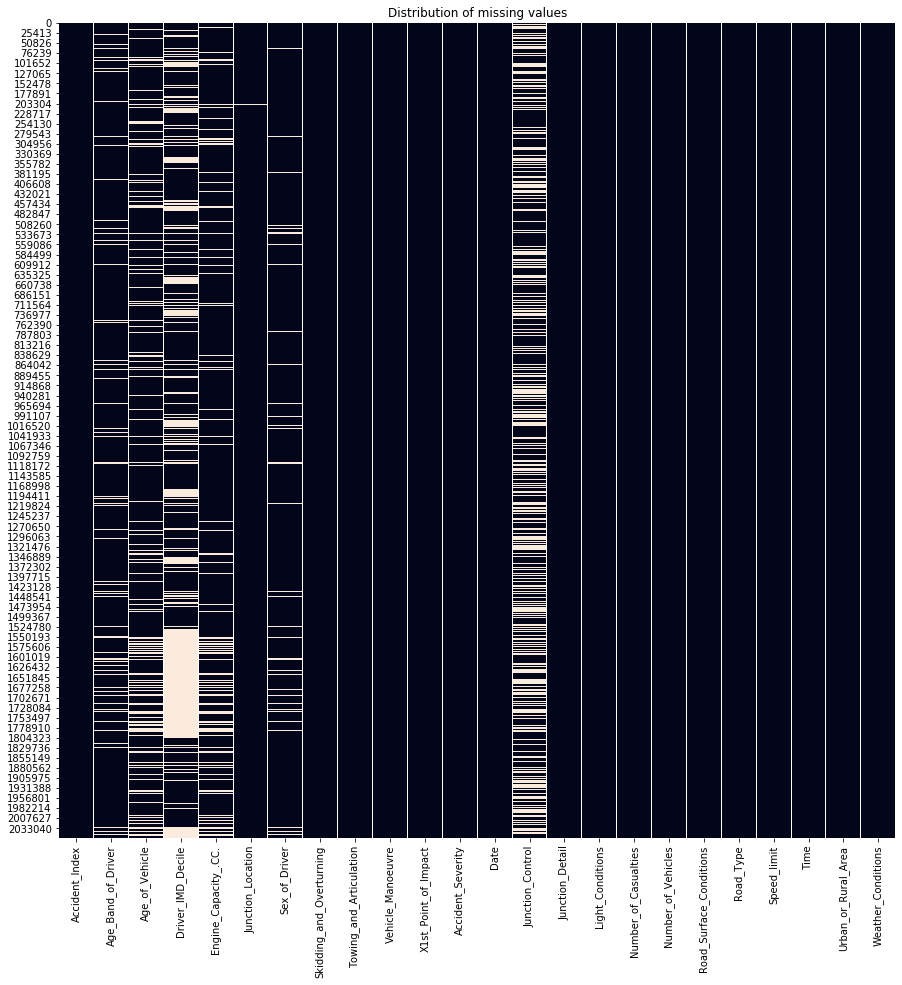

In [7]:
# Distribution of missing values in the dataset
# White lines indicate missing values

plt.figure(figsize=(15,15))
sns.heatmap(mod_acc_vehicle_info.isnull(), cbar=False)
plt.title('Distribution of missing values')
plt.show()

In [8]:
# filling the Driver IMD decile with mean
mod_acc_vehicle_info['Driver_IMD_Decile'].fillna(mod_acc_vehicle_info['Driver_IMD_Decile'].mean(), inplace = True)

In [9]:
# Dropping rows with many null values (0.5* 21 = 0.4375*24)
mod_acc_vehicle_info = drop_useless_rows(mod_acc_vehicle_info, threshold = 0.4375, target = None)

In [10]:
# deleting useless variables and functions, to free RAM
del(drop_useless_cols)
del(drop_useless_rows)
# for checking the virtual memory available
print("memory usage :\n\n",psutil.virtual_memory())

memory usage :

 svmem(total=17066516480, available=6724194304, percent=60.6, used=10342322176, free=6724194304)


In [11]:
# importing the label encoded and imputed file
imp_le_df = pd.read_csv('mf_bin_imputed.csv')
# for checking the virtual memory available
print("memory usage :\n\n",psutil.virtual_memory())

memory usage :

 svmem(total=17066516480, available=6463270912, percent=62.1, used=10603245568, free=6463270912)


In [12]:
imp_le_df['Date'] = mod_acc_vehicle_info['Date']
imp_le_df['Driver_IMD_Decile'] = mod_acc_vehicle_info['Driver_IMD_Decile']
imp_le_df['Time'] = mod_acc_vehicle_info['Time']
imp_le_df['Speed_limit'] = mod_acc_vehicle_info['Speed_limit']
imp_le_df


,Age_Band_of_Driver,Age_of_Vehicle,Engine_Capacity_.CC.,Junction_Location,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Manoeuvre,X1st_Point_of_Impact,Accident_Severity,...,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Urban_or_Rural_Area,Weather_Conditions,Date,Driver_IMD_Decile,Time,Speed_limit
0,6.000,3.0000,8268.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,2005-01-05,5.385381,17:36,30.0
1,5.000,5.0000,8300.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,2.0,0.0,1.0,0.0,0.0,2005-01-06,3.000000,00:15,30.0
2,7.000,4.0000,1769.000000,1.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,2005-01-07,1.000000,10:35,30.0
3,7.000,10.0000,85.000000,1.0,0.0,1.0,0.0,2.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,2005-01-10,5.385381,21:13,30.0
4,7.000,1.0000,2976.000000,1.0,0.0,0.0,0.0,3.0,2.0,0.0,...,1.0,2.0,1.0,1.0,0.0,1.0,2005-01-11,4.000000,12:40,30.0
5,5.000,2.0000,124.000000,1.0,1.0,0.0,0.0,2.0,2.0,0.0,...,1.0,2.0,1.0,1.0,0.0,1.0,2005-01-11,2.000000,12:40,30.0
6,5.000,16.9100,978.969000,2.0,0.0,0.0,0.0,2.0,1.0,0.0,...,1.0,2.0,0.0,1.0,0.0,0.0,2005-01-13,5.385381,20:40,30.0
7,6.000,4.0000,4266.000000,2.0,0.0,0.0,0.0,4.0,3.0,0.0,...,1.0,2.0,0.0,1.0,0.0,0.0,2005-01-13,6.000000,20:40,30.0
8,9.000,16.0000,5343.000000,1.0,0.0,0.0,0.0,2.0,1.0,0.0,...,2.0,1.0,0.0,0.0,0.0,0.0,2005-01-14,7.000000,17:35,30.0
9,5.000,6.0000,1988.000000,3.0,0.0,0.0,0.0,2.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,2005-01-16,3.000000,00:42,30.0


In [13]:
imp_le_df.to_csv('mod_imp_mf.csv')
print("processed")

processed


In [14]:
# pre processing date
imp_le_df['Date'] = pd.to_datetime(imp_le_df['Date'], format = '%Y-%m-%d')
# setting date as index
imp_le_df.set_index(imp_le_df['Date'], inplace = True)
imp_le_df.head()

,Age_Band_of_Driver,Age_of_Vehicle,Engine_Capacity_.CC.,Junction_Location,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Manoeuvre,X1st_Point_of_Impact,Accident_Severity,...,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Urban_or_Rural_Area,Weather_Conditions,Date,Driver_IMD_Decile,Time,Speed_limit
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-05,6.0,3.0,8268.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,2005-01-05,5.385381,17:36,30.0
2005-01-06,5.0,5.0,8300.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,2.0,0.0,1.0,0.0,0.0,2005-01-06,3.000000,00:15,30.0
2005-01-07,7.0,4.0,1769.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,2005-01-07,1.000000,10:35,30.0
2005-01-10,7.0,10.0,85.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,2005-01-10,5.385381,21:13,30.0
2005-01-11,7.0,1.0,2976.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,...,1.0,2.0,1.0,1.0,0.0,1.0,2005-01-11,4.000000,12:40,30.0


## useful functions

In [29]:
def nunique_table(df, which=None, ascending=False):
    """
    Counts number of unique values for specified/all columns of the pandas DataFrame. Columns
    with few unique values could potentially be represented as categorical variables.
    
    :params:
        which:      (list) function returns unique value counts only for columns 
                    specified in this list. Default (None) returns counts for all columns
        ascending:  (boolean) sorts table in ascending order of missing values
                    if set to True, default is False 
                    
    :return: pandas DataFrame object column name, number of unique values and percentage of 
             total values which are unique
    """
    cols = df.columns
    unique_vals = np.array([df[col].nunique() for col in cols])
    percentage = (unique_vals / len(df))*100
    
    unique_table = pd.DataFrame(np.vstack((cols, unique_vals, percentage)).T,
                                columns=['column', 'unique values', '% of total'])
    unique_table = unique_table.sort_values(by='unique values', ascending=ascending)
    
    if which is None:
        return unique_table
    else:
        part_cols = np.array(which)
        unique_vals = df[which].nunique().values
        percentage = (unique_vals/len(df))*100
        
        unique_table = pd.DataFrame(np.vstack((part_cols, unique_vals, percentage)).T,
                             columns=['column', 'unique values', '% of total'])
        unique_table['unique values'] = unique_table['unique values'].astype('int')
        unique_table['% of total'] = unique_table['% of total'].astype('float')
        unique_table = unique_table.sort_values(by='unique values', ascending=ascending)
        return unique_table

    
from scipy.stats import probplot

def Dashboard(df, num_cols=None):
    """
    Displays distribution and prob-plots for numeric columns in the input dataset side-by-side
    
    :param num_cols: (list-like) List of columns with numeric data (non-object)
    
    :return:
        Displays series of plots with histogram of column data and prob-plot side-by-side
    """
    if num_cols is None:
        raise ValueError('Numeric columns not specified')
    else:
        for col in num_cols:
            plt.figure(figsize=(13,5))

            # Plot histogram of values
            plt.subplot(121)
            plt.hist(df[col], bins=20, edgecolor='black')
            plt.grid()
            plt.title(col)
            plt.ylabel('frequency')

            # Plot probplot for normal distribution
            plt.subplot(122)
            probplot(df.loc[df[col].notnull(), col].values, dist='norm', plot=plt)
            plt.grid()
            plt.title(col)

            plt.tight_layout()
            plt.show()


def pair_wise_plotter(df, target=None, cols=None):
    """
    Displays pair plots for specified columns from input data. Target column is also plotted
    to detect any possible data leakage.
    
    :param target: (string) Name of target column in the dataset
    :param cols: (list-like) List of columns whose pair-plots are to be displayed
    
    :return:
        Plot with pair plots of specified columns and target columns from dataset
    """
    if cols is not None:
        df = df[cols+[target]]
    
    sns.pairplot(df, hue=target, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
                 size = 4)
    plt.title('Pairplots')
    plt.show()

In [21]:
# finding the unique values in categorical columns
nunique_table(imp_le_df)

,column,unique values,% of total
2,Engine_Capacity_.CC.,184778,8.97689
1,Age_of_Vehicle,21588,1.04879
0,Age_Band_of_Driver,8995,0.436995
19,Date,4383,0.212935
21,Time,1439,0.0699095
13,Number_of_Casualties,50,0.0024291
14,Number_of_Vehicles,27,0.00131171
7,Vehicle_Manoeuvre,18,0.000874477
20,Driver_IMD_Decile,11,0.000534402
18,Weather_Conditions,9,0.000437238


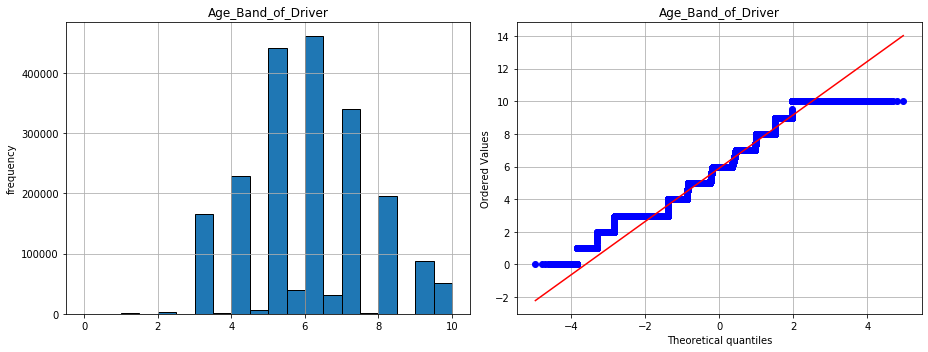

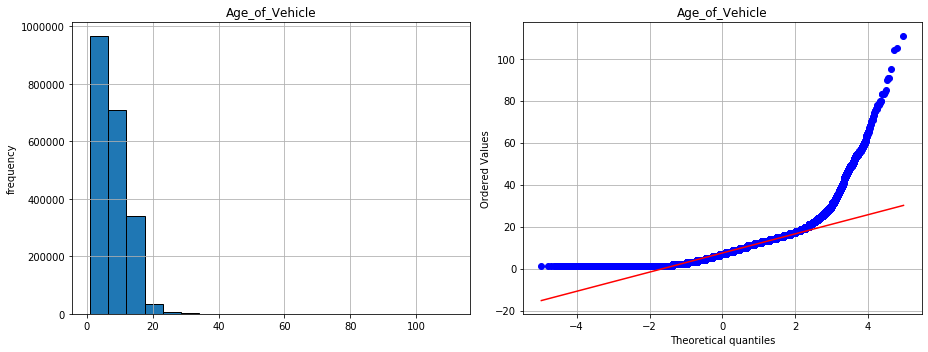

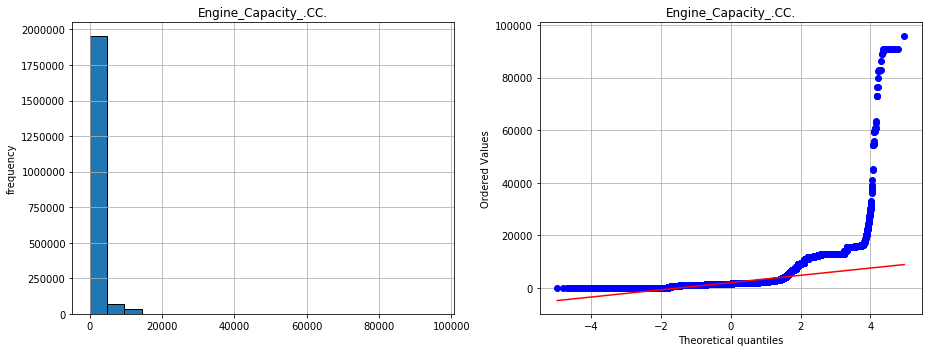

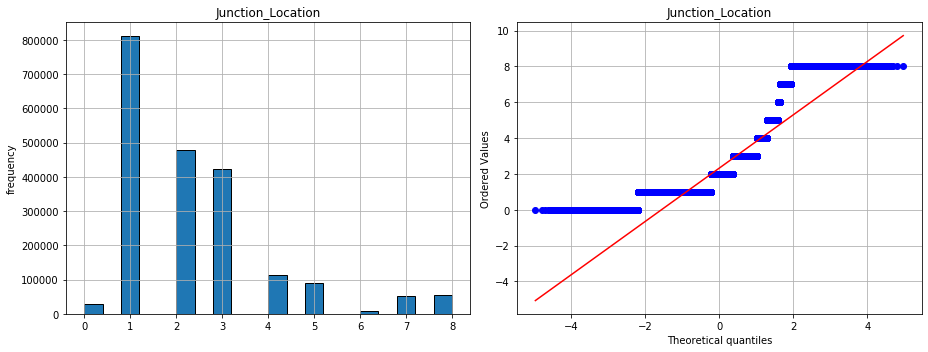

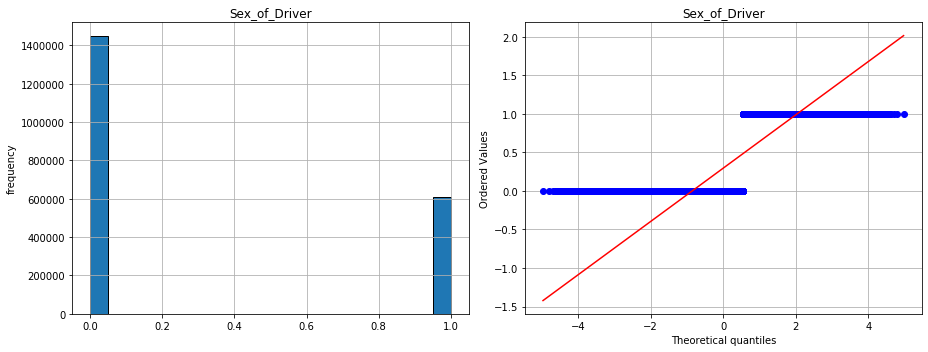

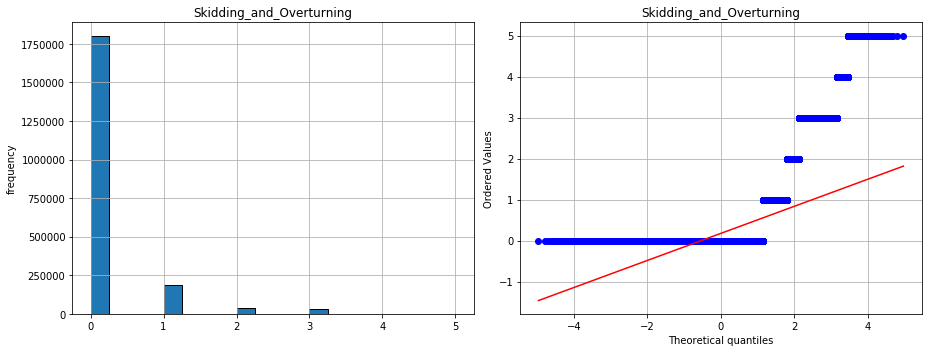

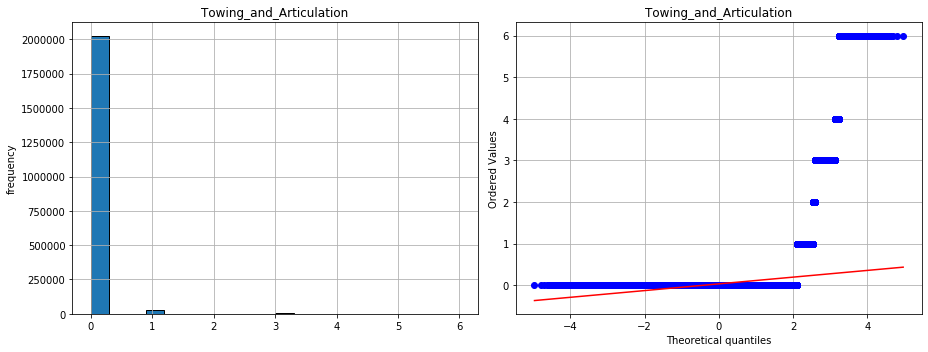

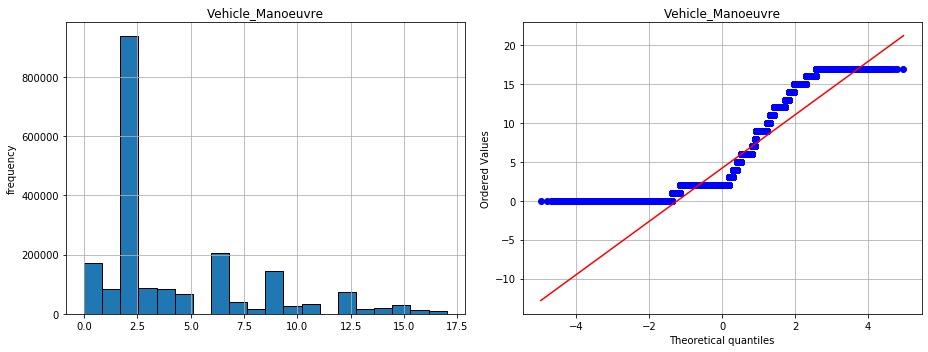

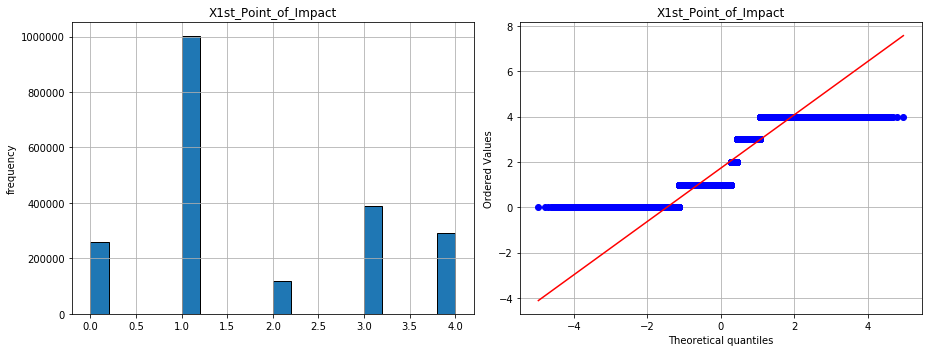

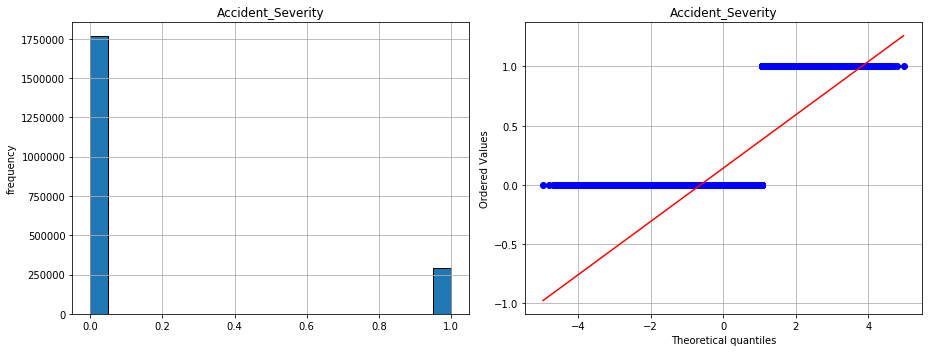

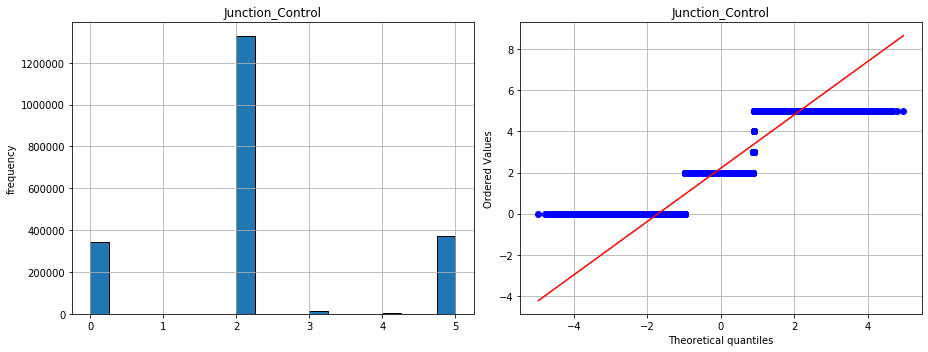

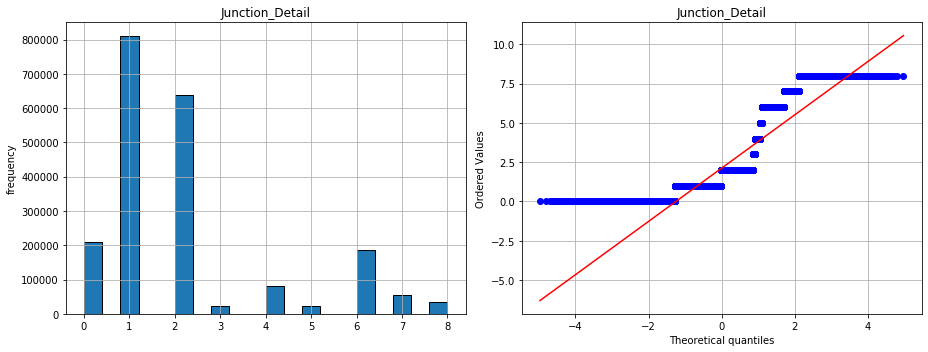

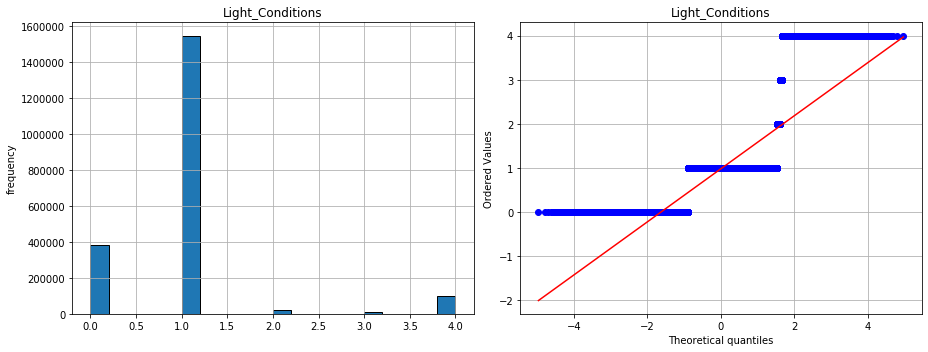

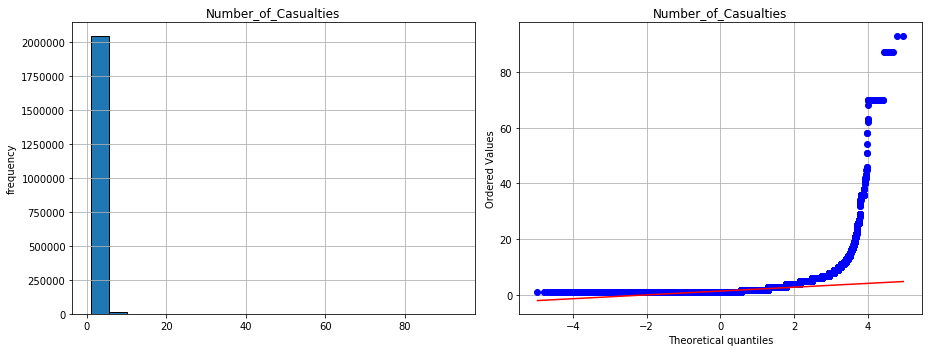

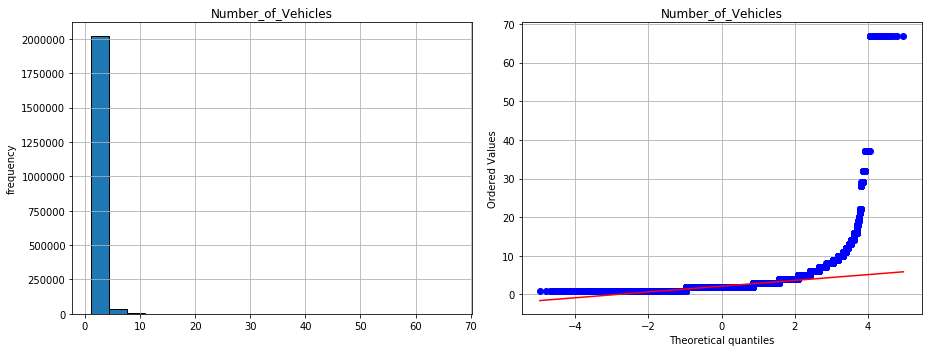

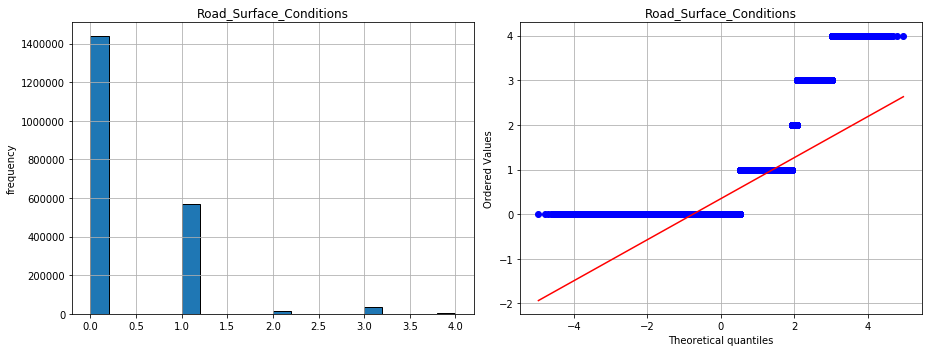

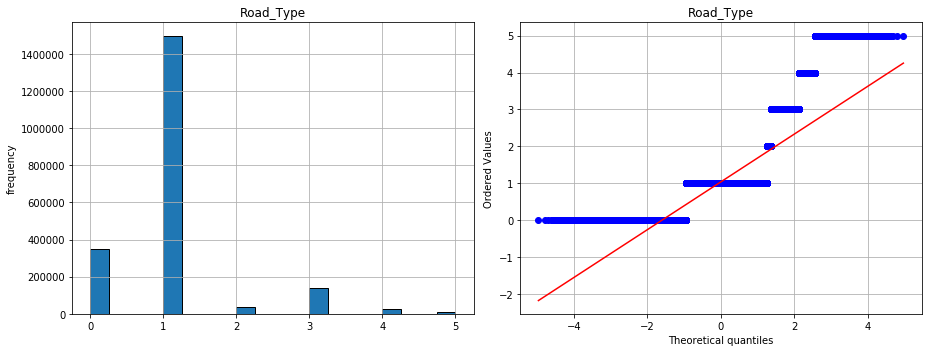

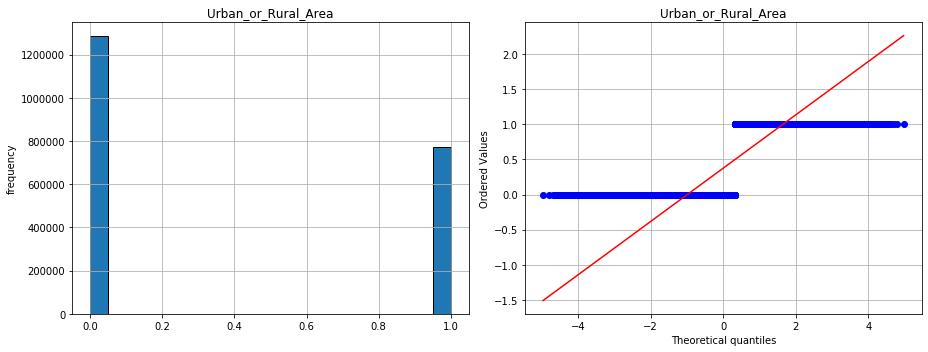

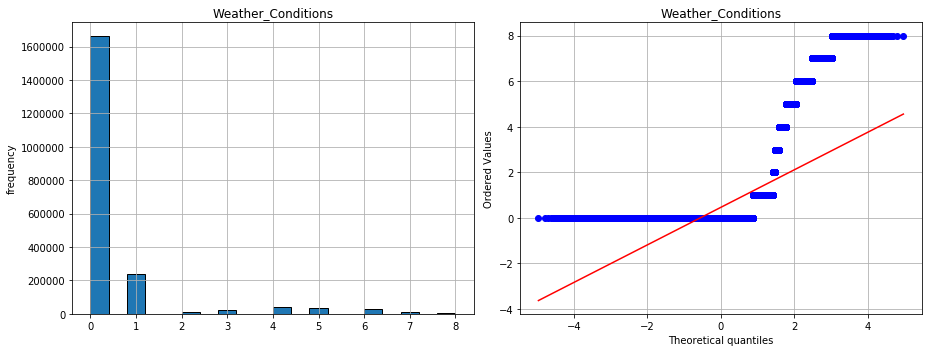

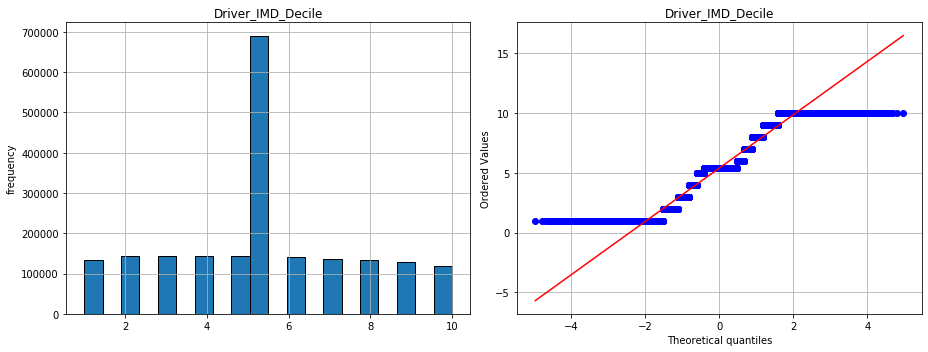

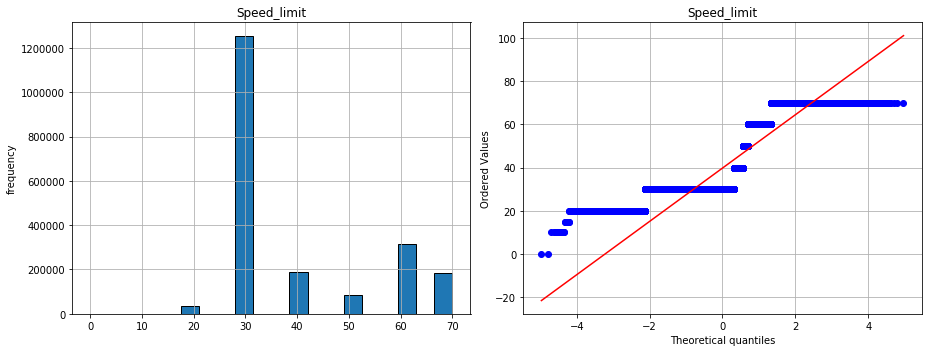

In [33]:
# Distributions with original data
imp_le_df = imp_le_df.drop(['Date', 'Time'],axis = 1)
cols = imp_le_df.columns
Dashboard(imp_le_df, num_cols = cols)

In [40]:
imp_le_df['Target'] = 1
n_acc = imp_le_df['Target'].resample('M', how = 'sum')
mod_df = imp_le_df.resample('M', how = 'mean')
# Adding target variable
mod_df['Target'] = n_acc
# n_acc

,Age_Band_of_Driver,Age_of_Vehicle,Engine_Capacity_.CC.,Junction_Location,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Manoeuvre,X1st_Point_of_Impact,Accident_Severity,...,Light_Conditions,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Urban_or_Rural_Area,Weather_Conditions,Driver_IMD_Decile,Speed_limit,Target
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,5.826669,6.316969,2377.967710,2.262255,0.258803,0.227158,0.037745,4.172957,1.711853,0.131646,...,1.011853,1.441772,2.129804,0.553855,1.010702,0.384120,0.781013,5.419577,41.105869,8690
2005-02-28,5.831652,6.236479,2410.437371,2.240418,0.261174,0.235324,0.040876,4.186935,1.718834,0.127849,...,0.994270,1.431682,2.127722,0.533427,1.018592,0.390679,0.681905,5.388250,41.083662,7853
2005-03-31,5.826369,6.256568,2375.236903,2.229692,0.265540,0.217381,0.041400,4.256488,1.698371,0.133253,...,0.966325,1.436934,2.112372,0.323355,1.030175,0.383585,0.418105,5.388091,40.648159,8285
2005-04-30,5.850301,6.179394,2402.153996,2.255999,0.270329,0.206187,0.046401,4.322074,1.756170,0.126237,...,0.986125,1.471284,2.164676,0.224610,1.021722,0.368020,0.354941,5.388869,40.142159,8793
2005-05-31,5.864886,6.187688,2352.668372,2.290418,0.267518,0.196919,0.045272,4.292740,1.746412,0.139932,...,0.991769,1.452301,2.108168,0.160405,1.055403,0.379907,0.262347,5.385703,40.278599,9476
2005-06-30,5.881214,6.128552,2343.435242,2.244849,0.261459,0.213730,0.044786,4.364802,1.744323,0.145500,...,0.997267,1.451009,2.110597,0.165475,1.055719,0.396657,0.251577,5.413855,40.896762,9512
2005-07-31,5.840525,6.129963,2309.149023,2.244609,0.260465,0.218076,0.053488,4.324207,1.771459,0.147463,...,1.000000,1.474630,2.104440,0.188372,1.054440,0.392706,0.275687,5.369830,40.872093,9460
2005-08-31,5.857052,6.141474,2339.347418,2.233470,0.259746,0.223993,0.059983,4.300991,1.757054,0.146565,...,0.984170,1.482124,2.129550,0.178333,1.049968,0.405988,0.279561,5.388493,41.536722,9286
2005-09-30,5.833356,6.012502,2337.202237,2.216925,0.263558,0.208806,0.047986,4.282815,1.736754,0.144166,...,0.992401,1.438534,2.116686,0.199334,1.043406,0.389299,0.328198,5.397391,40.654731,9607


## Adding some important features

In [41]:
# other features
mod_df['tvec'] = np.arange(0,len(mod_df))
mod_df['log_tvec'] = np.log(mod_df.tvec+1)

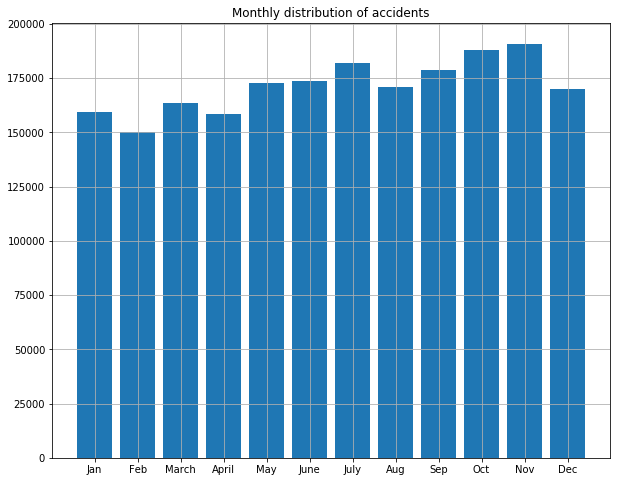

ascending order of accident months :
Feb
April
Jan
March
Dec
Aug
May
June
Sep
July
Oct
Nov



In [79]:
# Adding month feature
mod_df['Month'] = mod_df['tvec']%12
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# histogram with frequency of accidents per month
temp = mod_df[['Month','Target']].groupby('Month').sum()
plt.figure(figsize = (10,8))
plt.bar(np.arange(0,12),temp.Target)
plt.title("Monthly distribution of accidents")
plt.xticks(np.arange(0,12), months)
plt.grid()
plt.show()

# sorted order of month-wise number of accidents
temp = np.array(temp)
res = np.argsort(temp.ravel())

print("ascending order of accident months :")
[print(months[res[i]]) for i in range(12)]
print()


In [86]:
# making a good correlated feature with target
mod_df['Month'] = np.array(months*12)

# now encoding months in ascending order of accidents
asc_months = [months[res[i]] for i in range(12)]
for i in range(12):
    mod_df.loc[mod_df['Month'] == asc_months[i], 'Month'] = i


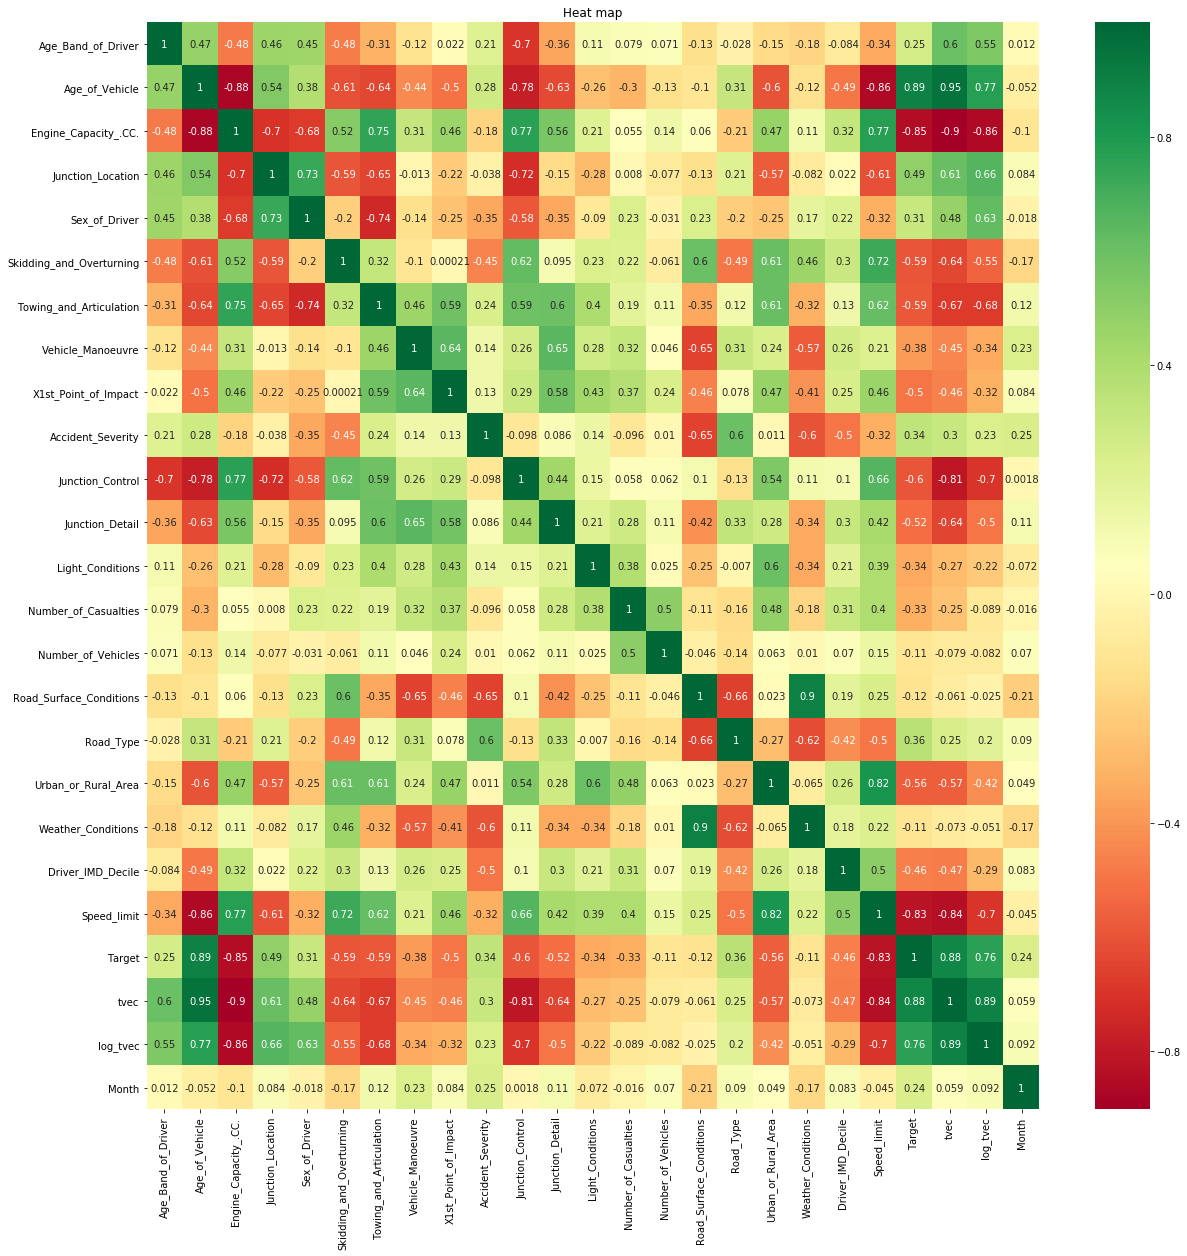

In [90]:
# Heatmap
plt.figure(figsize = (20,20))
plt.title("Heat map")
sns.heatmap(mod_df.corr(),annot=True,cmap="RdYlGn")
plt.show()

## Applying model to regress

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = mod_df.drop(['Target'], axis = 1)
Y = mod_df.Target.values

In [93]:
# splitting the data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [95]:
# base model
rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, Y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, Y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_val, Y_val)))

R^2 Training Score: 0.99 
OOB Score: 0.96 
R^2 Validation Score: 0.95


## Feature Importance

In [97]:
# feature importance for random forest model
rf.feature_importances_

array([0.00177694, 0.14586366, 0.29001959, 0.00131781, 0.01011922,
       0.00076529, 0.00119597, 0.00111803, 0.00053116, 0.00388392,
       0.00166465, 0.00316168, 0.00164072, 0.00867133, 0.00157027,
       0.00139113, 0.00262099, 0.00064221, 0.00240399, 0.00108088,
       0.00060674, 0.27293306, 0.20664828, 0.0383725 ])

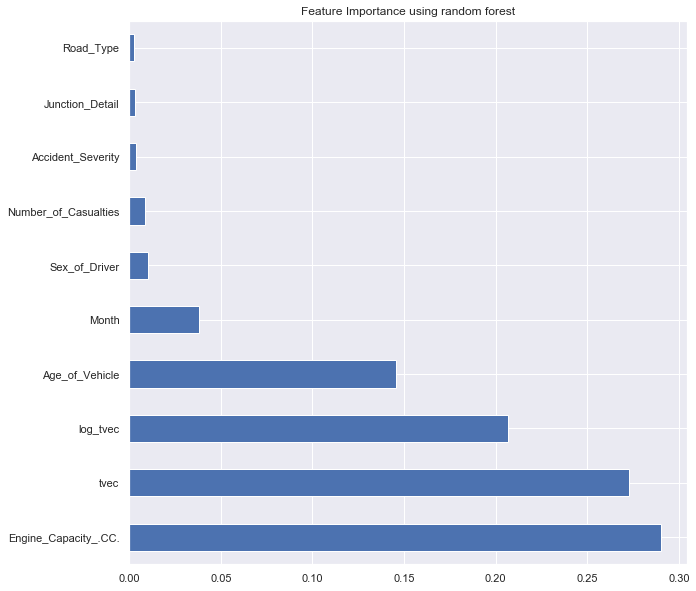

In [101]:
from sklearn.feature_selection import SelectKBest

sns.set()
plt.figure(figsize = (10,10))
plt.title("Feature Importance using random forest")
imp_features = pd.Series(rf.feature_importances_, index = X.columns)
imp_features.nlargest(10).plot(kind = 'barh')
plt.show()


## Results

The top 10 features obtained are :
 1. Engine_Capacity_CC
 2. tvec - vector of month and year together.
 3. log of tvec
 4. Age_of_vehicle
 5. Month
 6. Sex_of_driver ratio involved in accident during the month
 7. Average of number of casualities involved in a month.
 8. Average accident severity in a month.
 9. Junction detail.
 10. Road_type.